# 协同过滤算法实践

In [1]:
# 导入包
import random
import math
import time

# 定义装饰器，监控运行时间；对其他函数进行计时功能的扩展
def timmer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        res = func(*args, **kwargs)
        stop_time = time.time()
        print('Func %s, run time: %s' % (func.__name__, stop_time - start_time))
        return res
    return wrapper

## 一、数据介绍

本实验使用MovieLens的ml-1m数据集，它包含了6040名用户对大约3900部电影的1000209条评分记录。

下载链接：http://files.grouplens.org/datasets/movielens/ml-1m.zip

数据已经下载至dataset文件夹中。

程序中引用的数据：fp = './dataset/ml-1m/ratings.dat'

数据格式：userid::movieid::rating::timestamp，如图所示：

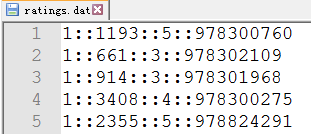


## 二、 通用函数

### 1. 数据处理

In [2]:
class Dataset():
    
    def __init__(self, fp):
        # fp: data file path
        self.data = self.loadData(fp)
    
    @timmer
    def loadData(self, fp):
        data = []
        for l in open(fp):
            data.append(tuple(map(int, l.strip().split('::')[:2])))
        return data
    
    @timmer
    def splitData(self, M, k, seed=1):
        '''
        :params: data, 加载的所有(user, item)数据条目
        :params: M, 划分的数目，最后需要取M折的平均
        :params: k, 本次是第几次划分，k~[0, M)
        :params: seed, random的种子数，对于不同的k应设置成一样的
        :return: train, test
        '''
        train, test = [], []
        random.seed(seed)
        for user, item in self.data:
            # 这里与书中的不一致，本人认为取M-1较为合理，因randint是左右都覆盖的
            if random.randint(0, M-1) == k:  
                test.append((user, item))
            else:
                train.append((user, item))

        # 处理成字典的形式，user->set(items)
        def convert_dict(data):
            data_dict = {}
            for user, item in data:
                if user not in data_dict:
                    data_dict[user] = set()
                data_dict[user].add(item)
            data_dict = {k: list(data_dict[k]) for k in data_dict}
            return data_dict

        return convert_dict(train), convert_dict(test)

### 2. 评价指标
准确率、召回率、覆盖度、流行度

In [3]:
class Metric():
    
    def __init__(self, train, test, GetRecommendation):
        '''
        :params: train, 训练数据
        :params: test, 测试数据
        :params: GetRecommendation, 为某个用户获取推荐物品的接口函数
        '''
        self.train = train
        self.test = test
        self.GetRecommendation = GetRecommendation
        self.recs = self.getRec()
        
    # 为test中的每个用户进行推荐
    def getRec(self):
        recs = {}
        for user in self.test:
            rank = self.GetRecommendation(user)
            recs[user] = rank
        return recs
        
    # 定义精确率指标计算方式
    def precision(self):
        all, hit = 0, 0
        for user in self.test:
            test_items = set(self.test[user])
            rank = self.recs[user]
            for item, score in rank:
                if item in test_items:
                    hit += 1
            all += len(rank)
        return round(hit / all * 100, 2)
    
    # 定义召回率指标计算方式
    def recall(self):
        all, hit = 0, 0
        for user in self.test:
            test_items = set(self.test[user])
            rank = self.recs[user]
            for item, score in rank:
                if item in test_items:
                    hit += 1
            all += len(test_items)
        return round(hit / all * 100, 2)
    
    # 定义覆盖率指标计算方式
    def coverage(self):
        all_item, recom_item = set(), set()
        for user in self.test:
            for item in self.train[user]:
                all_item.add(item)
            rank = self.recs[user]
            for item, score in rank:
                recom_item.add(item)
        return round(len(recom_item) / len(all_item) * 100, 2)
    
    # 定义新颖度指标计算方式
    def popularity(self):
        # 计算物品的流行度
        item_pop = {}
        for user in self.train:
            for item in self.train[user]:
                if item not in item_pop:
                    item_pop[item] = 0
                item_pop[item] += 1

        num, pop = 0, 0
        for user in self.test:
            rank = self.recs[user]
            for item, score in rank:
                # 取对数，防止因长尾问题带来的被流行物品所主导
                pop += math.log(1 + item_pop[item])
                num += 1
        return round(pop / num, 6)
    
    def eval(self):
        metric = {'Precision': self.precision(),
                  'Recall': self.recall(),
                  'Coverage': self.coverage(),
                  'Popularity': self.popularity()}
        print('Metric:', metric)
        return metric

## 三、算法实现

### 1. 基于用户的协同过滤算法

#### 1.1 基于改进的用户余弦相似度的推荐

In [4]:
def UserIIF(train, K, N):
    '''
    :params: train, 训练数据集
    :params: K, 超参数，设置取TopK相似用户数目
    :params: N, 超参数，设置取TopN推荐物品数目
    :return: GetRecommendation, 推荐接口函数
    '''
    # 计算item->user的倒排索引，每个物品->3.喜好它的用户
    item_users = {}
    for user in train:
        for item in train[user]:
            if item not in item_users:
                item_users[item] = []
            item_users[item].append(user)
    
    # 计算用户相似度矩阵
    sim = {}
    num = {}
    for item in item_users:
        users = item_users[item]
        for i in range(len(users)):
            u = users[i]
            if u not in num:
                num[u] = 0
            num[u] += 1
            if u not in sim:
                sim[u] = {}
            for j in range(len(users)):
                if j == i: continue
                v = users[j]
                if v not in sim[u]:
                    sim[u][v] = 0
                # 相比UserCF，主要是改进了这里
                sim[u][v] += 1 / math.log(1 + len(users))
    for u in sim:
        for v in sim[u]:
            sim[u][v] /= math.sqrt(num[u] * num[v])
    
    # 按照相似度排序
    sorted_user_sim = {k: list(sorted(v.items(), \
                               key=lambda x: x[1], reverse=True)) \
                       for k, v in sim.items()}
    
    # 获取接口函数
    def GetRecommendation(user):
        items = {}
        seen_items = set(train[user])
        for u, _ in sorted_user_sim[user][:K]:
            for item in train[u]:
                # 要去掉用户见过的
                if item not in seen_items:
                    if item not in items:
                        items[item] = 0
                    items[item] += sim[user][u]
        recs = list(sorted(items.items(), key=lambda x: x[1], reverse=True))[:N]
        return recs
    
    return GetRecommendation

### 2. 基于物品的协同过滤算法

#### 2.1 基于改进的物品余弦相似度的推荐

In [5]:
def ItemIUF(train, K, N):
    '''
    :params: train, 训练数据集
    :params: K, 超参数，设置取TopK相似物品数目
    :params: N, 超参数，设置取TopN推荐物品数目
    :return: GetRecommendation, 推荐接口函数
    ''' 
    # 计算物品相似度矩阵
    sim = {}
    num = {}
    for user in train:
        items = train[user]
        for i in range(len(items)):
            u = items[i]
            if u not in num:
                num[u] = 0
            num[u] += 1
            if u not in sim:
                sim[u] = {}
            for j in range(len(items)):
                if j == i: continue
                v = items[j]
                if v not in sim[u]:
                    sim[u][v] = 0
                # 相比ItemCF，主要是改进了这里
                sim[u][v] += 1 / math.log(1 + len(items))
    for u in sim:
        for v in sim[u]:
            sim[u][v] /= math.sqrt(num[u] * num[v])
    
    # 按照相似度排序
    sorted_item_sim = {k: list(sorted(v.items(), \
                               key=lambda x: x[1], reverse=True)) \
                       for k, v in sim.items()}
    
    # 获取接口函数
    def GetRecommendation(user):
        items = {}
        seen_items = set(train[user])
        for item in train[user]:
            for u, _ in sorted_item_sim[item][:K]:
                # 要去掉用户见过的
                if u not in seen_items:
                    if u not in items:
                        items[u] = 0
                    items[u] += sim[item][u]
        recs = list(sorted(items.items(), key=lambda x: x[1], reverse=True))[:N]
        return recs
    
    return GetRecommendation

#### 2.2 基于归一化的物品余弦相似度的推荐

In [6]:
def ItemCF_Norm(train, K, N):
    '''
    :params: train, 训练数据集
    :params: K, 超参数，设置取TopK相似物品数目
    :params: N, 超参数，设置取TopN推荐物品数目
    :return: GetRecommendation, 推荐接口函数
    '''
    # 计算物品相似度矩阵
    sim = {}
    num = {}
    for user in train:
        items = train[user]
        for i in range(len(items)):
            u = items[i]
            if u not in num:
                num[u] = 0
            num[u] += 1
            if u not in sim:
                sim[u] = {}
            for j in range(len(items)):
                if j == i: continue
                v = items[j]
                if v not in sim[u]:
                    sim[u][v] = 0
                sim[u][v] += 1
    for u in sim:
        for v in sim[u]:
            sim[u][v] /= math.sqrt(num[u] * num[v])
            
    # 对相似度矩阵进行按行归一化
    for u in sim:
        s = 0
        for v in sim[u]:
            s += sim[u][v]
        if s > 0:
            for v in sim[u]:
                sim[u][v] /= s
    
    # 按照相似度排序
    sorted_item_sim = {k: list(sorted(v.items(), \
                               key=lambda x: x[1], reverse=True)) \
                       for k, v in sim.items()}
    
    # 获取接口函数
    def GetRecommendation(user):
        items = {}
        seen_items = set(train[user])
        for item in train[user]:
            for u, _ in sorted_item_sim[item][:K]:
                if u not in seen_items:
                    if u not in items:
                        items[u] = 0
                    items[u] += sim[item][u]
        recs = list(sorted(items.items(), key=lambda x: x[1], reverse=True))[:N]
        return recs
    
    return GetRecommendation

## 四、实验测试

In [7]:
class Experiment():
    
    def __init__(self, M, K, N, fp='./dataset/ml-1m/ratings.dat', rt='UserIIF'):
        '''
        :params: M, 进行多少次实验
        :params: K, TopK相似用户的个数
        :params: N, TopN推荐物品的个数
        :params: fp, 数据文件路径
        :params: rt, 推荐算法类型
        '''
        self.M = M
        self.K = K
        self.N = N
        self.fp = fp
        self.rt = rt
        self.alg = { 'UserIIF': UserIIF, 'ItemIUF': ItemIUF, 'ItemCF_Norm':ItemCF_Norm}
    
    # 定义单次实验
    @timmer
    def worker(self, train, test):
        '''
        :params: train, 训练数据集
        :params: test, 测试数据集
        :return: 各指标的值
        '''
        getRecommendation = self.alg[self.rt](train, self.K, self.N)
        metric = Metric(train, test, getRecommendation)
        return metric.eval()
    
    # 多次实验取平均
    @timmer
    def run(self):
        metrics = {'Precision': 0, 'Recall': 0, 
                   'Coverage': 0, 'Popularity': 0}
        dataset = Dataset(self.fp)
        for ii in range(self.M):
            train, test = dataset.splitData(self.M, ii)
            print('Experiment {}:'.format(ii))
            metric = self.worker(train, test)
            metrics = {k: metrics[k]+metric[k] for k in metrics}
        metrics = {k: metrics[k] / self.M for k in metrics}
        print('Average Result (M={}, K={}, N={}): {}'.format(\
                              self.M, self.K, self.N, metrics))

### 1. UserIIF

实验次数较多，故提前终止了

In [8]:
M, N = 8, 10
for K in [5, 10, 20, 40, 80, 160]:
    cf_exp = Experiment(M, K, N, rt='UserIIF')
    cf_exp.run()

Func loadData, run time: 2.4531404972076416
Func splitData, run time: 2.5401451587677
Experiment 0:
Metric: {'Precision': 16.5, 'Recall': 7.92, 'Coverage': 54.72, 'Popularity': 6.749502}
Func worker, run time: 546.3842515945435
Func splitData, run time: 2.776158571243286
Experiment 1:
Metric: {'Precision': 16.42, 'Recall': 7.86, 'Coverage': 54.58, 'Popularity': 6.746944}
Func worker, run time: 541.0259447097778
Func splitData, run time: 3.6592092514038086
Experiment 2:
Metric: {'Precision': 16.43, 'Recall': 7.85, 'Coverage': 54.07, 'Popularity': 6.753636}
Func worker, run time: 537.7927598953247
Func splitData, run time: 10.723613500595093
Experiment 3:
Metric: {'Precision': 16.47, 'Recall': 7.92, 'Coverage': 54.82, 'Popularity': 6.747033}
Func worker, run time: 565.1773264408112
Func splitData, run time: 10.574604749679565
Experiment 4:
Metric: {'Precision': 16.47, 'Recall': 7.92, 'Coverage': 54.48, 'Popularity': 6.755975}
Func worker, run time: 533.7605290412903
Func splitData, run t

KeyboardInterrupt: 

### 2. ItemIUF

实验次数较多，故提前终止了

In [9]:
M, N = 8, 10
for K in [5, 10, 20, 40, 80, 160]:
    cf_exp = Experiment(M, K, N, rt='ItemIUF')
    cf_exp.run()

Func loadData, run time: 3.328190565109253
Func splitData, run time: 2.983170509338379
Experiment 0:
Metric: {'Precision': 21.99, 'Recall': 10.56, 'Coverage': 20.08, 'Popularity': 7.2641}
Func worker, run time: 303.3693518638611
Func splitData, run time: 2.6661524772644043
Experiment 1:
Metric: {'Precision': 22.3, 'Recall': 10.68, 'Coverage': 19.96, 'Popularity': 7.255367}
Func worker, run time: 272.8526060581207
Func splitData, run time: 2.6801531314849854
Experiment 2:
Metric: {'Precision': 22.17, 'Recall': 10.6, 'Coverage': 20.03, 'Popularity': 7.260025}
Func worker, run time: 278.10190653800964
Func splitData, run time: 3.005171775817871
Experiment 3:


KeyboardInterrupt: 

### 3. ItemCF_Norm

实验次数较多，故提前终止了

In [10]:
M, N = 8, 10
for K in [5, 10, 20, 40, 80, 160]:
    cf_exp = Experiment(M, K, N, rt='ItemCF_Norm')
    cf_exp.run()

Func loadData, run time: 2.147122621536255
Func splitData, run time: 5.6733245849609375
Experiment 0:
Metric: {'Precision': 21.14, 'Recall': 10.15, 'Coverage': 42.36, 'Popularity': 6.782398}
Func worker, run time: 165.55646920204163
Func splitData, run time: 2.5941483974456787
Experiment 1:
Metric: {'Precision': 21.39, 'Recall': 10.24, 'Coverage': 42.33, 'Popularity': 6.777217}
Func worker, run time: 166.31851291656494
Func splitData, run time: 2.8071606159210205
Experiment 2:


KeyboardInterrupt: 